In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from utils.data import *
from utils.metrics import *

In [3]:
# Read training data frame, ignore duplicate rows
df = pd.read_csv('../data/train.csv').drop_duplicates()
df.shape

(114765, 13)

In [4]:
# Explore feature dofs
[print(colname, df[colname].unique().size) for colname in sorted(df.columns)];

action_recommendation_category 6
action_recommendation_id 295
action_recommendation_type 3
case_id 73945
completion_date 466
equipment_area 1285
equipment_category 20
equipment_id 30000
feedback 2
floors_category 8
load_category 8
speed_category 8
usage_type 13


<BarContainer object of 295 artists>

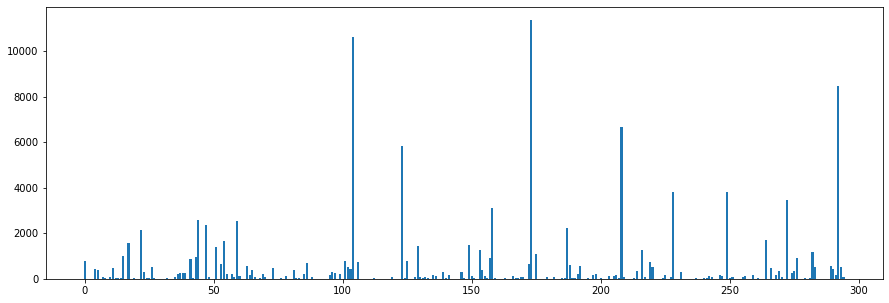

In [5]:
# Plot incidence counts for each action recommendation id
action_recommendation_groups = df.groupby('action_recommendation_id').size()
action_recommendation_index = np.arange(len(action_recommendation_groups.index))
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(action_recommendation_index, action_recommendation_groups.values)

In [6]:
# Group dataframe rows by false positives and true positives to get baseline f2 score, accuracy for label
df_fp = df[df.feedback == 0]
df_tp = df[df.feedback == 1]
baseline_label_score = f2_score(df.feedback.values, np.ones_like(df.feedback.values))
baseline_label_acc = len(df_tp) / len(df)
baseline_label_acc, baseline_label_score

(0.8772012373110268, 0.9727646762121391)

In [7]:
# Group by selected features and compute metrics for each group
group_names = [
    'action_recommendation_id',
    'action_recommendation_category',
    'equipment_category',
    'usage_type'
]
groups = compute_group_metrics(
    df,
    group_names,
    label_name='feedback'
)
groups

total_count  \
action_recommendation_id action_recommendation_category equipment_category usage_type                
ar00000209               arc02                          tp002              ut011            2858.0   
ar00000293               arc02                          tp002              ut011            3613.0   
ar00000174               arc03                          tp006              ut007            1497.0   
ar00000048               arc02                          tp002              ut011            1034.0   
ar00000293               arc02                          tp007              ut011            1311.0   
...                                                                                            ...   
ar00000193               arc03                          tp004              ut005              43.0   
                                                                           ut008              26.0   
                                                        tp005              ut001               6.0   
                                                                           ut005              15.0   
ar00000140               arc03                          tp001              ut001               5.0   

                                                                                       tp_count  \
action_recommendation_id action_recommendation_category equipment_category usage_type             
ar00000209               arc02                          tp002              ut011         2034.0   
ar00000293               arc02                          tp002              ut011         2994.0   
ar00000174               arc03                          tp006              ut007         1039.0   
ar00000048               arc02                          tp002              ut011          670.0   
ar00000293               arc02                          tp007              ut011         1019.0   
...                                                                                         ...   
ar00000193               arc03                          tp004              ut005           42.0   
                                                                           ut008           25.0   
                                                        tp005              ut001            5.0   
                                                                           ut005           14.0   
ar00000140               arc03                          tp001              ut001            4.0   

                                                                                       fp_count  \
action_recommendation_id action_recommendation_category equipment_category usage_type             
ar00000209               arc02                          tp002              ut011            824   
ar00000293               arc02                          tp002              ut011            619   
ar00000174               arc03                          tp006              ut007            458   
ar00000048               arc02                          tp002              ut011            364   
ar00000293               arc02                          tp007              ut011            292   
...                                                                                         ...   
ar00000193               arc03                          tp004              ut005              1   
                                                                           ut008              1   
                                                        tp005              ut001              1   
                                                                           ut005              1   
ar00000140               arc03                          tp001              ut001              1   

                                                                                       accuracy  
action_recommendation_id action_recommendation_category equipment_category usage_type 

In [8]:
%%time
# Using the groups, assign a group id for each row
group_ids = compute_group_index(
    df,
    groups,
    metric_name='accuracy',
    l_bound=0.70,
    h_bound=0.95
)

CPU times: user 1min 3s, sys: 93.1 ms, total: 1min 3s
Wall time: 1min 3s


In [9]:
# Apply assignment, dataframe now contains new column "group_type" which indicates the accuracy group
# to which the row belongs. 0=unknown, 1=lower group, 2=middle group, 3=upper group
df = df.assign(group_type=group_ids)
df

,case_id,equipment_id,completion_date,action_recommendation_id,action_recommendation_type,action_recommendation_category,equipment_area,usage_type,speed_category,load_category,floors_category,equipment_category,feedback,group_type
0,b7c775ad-4ebe-4848-9c53-37e7c5658e21,ele0000754,2018-10-03,ar00000174,art01,arc03,ga00000803,ut012,7,6,8,tp006,1,3
1,b177eefd-3946-4949-9699-0a91879350f9,ele0000789,2018-10-03,ar00000248,art02,arc03,ga00000269,ut005,4,6,2,tp001,1,0
2,fc2d568a-c53c-43ef-8871-a49ec22ab3b1,ele0001227,2018-10-03,ar00000158,art02,arc03,ga00000064,ut011,6,6,7,tp006,1,2
3,8e645922-1268-4c6b-ae6b-7b1605689cca,ele0001754,2018-10-03,ar00000105,art01,arc03,ga00000662,ut005,8,7,8,tp014,1,2
4,b44f10b1-9238-44db-8f0c-2d68e8c015a7,ele0002087,2018-10-03,ar00000148,art02,arc03,ga00001256,ut011,7,6,8,tp013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115470,8eda4489-c34c-4e8a-b592-ad57b5fd842a,ele0029759,2020-01-30,ar00000124,art01,arc03,ga00000817,ut011,6,7,8,tp005,1,2
115471,0113eba6-6928-461a-b994-35a0b2eb9f4e,ele0029783,2020-01-30,ar00000291,art02,arc01,ga00001027,ut001,4,3,1,tp015,1,0
115472,c2eab0dc-218a-4a95-ab28-47449f42f660,ele0029785,2020-01-30,ar00000048,art01,arc02,ga00000355,ut011,2,1,4,tp002,1,1
115473,c2eab0dc-218a-4a95-ab28-47449f42f660,ele0029785,2020-01-30,ar00000293,art01,arc02,ga00000355,ut011,2,1,4,tp002,1,2


In [10]:
df.groupby('group_type').size()

group_type
0    19720
1     9999
2    67203
3    17843
dtype: int64

In [11]:
# Save as new dataset
df.to_csv('../data/train-aug.csv', encoding='utf-8', index=False)

In [18]:
baseline_accuracy_values = []
for group_type in range(4):
    subset = df[df.group_type == group_type]
    baseline_accuracy_values.append(subset[subset.feedback == 1].size / subset.size)
    print(f'Group {group_type} baseline accuracy:', baseline_accuracy_values[-1])

Group 0 baseline accuracy: 0.9829614604462474
Group 1 baseline accuracy: 0.5963596359635963
Group 2 baseline accuracy: 0.8635923991488476
Group 3 baseline accuracy: 0.968951409516337


# Test data

In [12]:
# Read test dataset
df_test = pd.read_csv('../data/test.csv')

In [13]:
# Apply group ids
group_ids_test = compute_group_index(
    df_test,
    groups,
    metric_name='accuracy',
    l_bound=0.70,
    h_bound=0.95
)

In [14]:
# Save as new dataset
df_test = df_test.assign(group_type=group_ids_test)
df_test.to_csv('../data/test-aug.csv', encoding='utf-8', index=False)

In [15]:
df_test.groupby('group_type').size()

group_type
0     5863
1     2666
2    16546
3     4353
dtype: int64